In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = 'QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv'
df = pd.read_csv(file_path)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756857 entries, 0 to 1756856
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         datetime64[ns]
 1   Close Candle      float64       
 2   Ticker Full Name  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 40.2+ MB


In [4]:
missing_values_per_column = df.isnull().sum()
print("Missing values per column:\n", missing_values_per_column)

Missing values per column:
 Timestamp           0
Close Candle        0
Ticker Full Name    0
dtype: int64


<span style="color:blue"> Смотрим минимальную и максимальную дату для каждой из 3 групп и сравниваем количество существующих записей с ожидаемым значением. Вывод показывает, что датасет неполный. </span>

In [5]:
tickers = df['Ticker Full Name'].unique()
print(f"Unique tickers: {tickers}")

record_counts = df['Ticker Full Name'].value_counts()
print(f"Record counts:\n{record_counts}")

min_max_timestamps = df.groupby('Ticker Full Name')['Timestamp'].agg(['min', 'max'])
min_max_timestamps['Difference'] = min_max_timestamps['max'] - min_max_timestamps['min']
min_max_timestamps['Difference_minutes'] = min_max_timestamps['Difference'].dt.total_seconds() / 60
print(f"\nMinutes in each interval:\n{min_max_timestamps[['min', 'max', 'Difference_minutes']]}")

Unique tickers: ['10 YEAR TREASURY NOTE FUTURES' 'E-MINI S&P 500 FUTURES'
 'FTSE CHINA A50 INDEX FUTURES']
Record counts:
E-MINI S&P 500 FUTURES           672899
FTSE CHINA A50 INDEX FUTURES     565443
10 YEAR TREASURY NOTE FUTURES    518515
Name: Ticker Full Name, dtype: int64

Minutes in each interval:
                                              min                 max  \
Ticker Full Name                                                        
10 YEAR TREASURY NOTE FUTURES 2020-01-01 18:01:00 2021-11-30 23:46:00   
E-MINI S&P 500 FUTURES        2020-01-01 18:01:00 2021-11-30 23:59:00   
FTSE CHINA A50 INDEX FUTURES  2020-01-01 20:01:00 2021-11-30 23:59:00   

                               Difference_minutes  
Ticker Full Name                                   
10 YEAR TREASURY NOTE FUTURES           1006905.0  
E-MINI S&P 500 FUTURES                  1006918.0  
FTSE CHINA A50 INDEX FUTURES            1006798.0  


<span style="color:blue"> Создаем полный временной ряд для каждой группы с шагом в одну минуту. Пропуски в данных заполняются, используя предыдущие или последующие значения. Операция необходима для получения беспрерывных данных. </span>

In [6]:
start = min_max_timestamps['min'].min()
end = min_max_timestamps['max'].max()
full_timestamps = pd.date_range(start=start, end=end, freq='T')
full_df = pd.DataFrame(full_timestamps, columns=['Timestamp']).merge(df[['Ticker Full Name']].drop_duplicates(), how='cross')
df_full = pd.merge(full_df, df, on=['Timestamp', 'Ticker Full Name'], how='left')
df_full = df_full.groupby('Ticker Full Name').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill')).reset_index(drop=True)

record_counts_after_fill = df_full['Ticker Full Name'].value_counts()
print(f"Record counts after filling:\n{record_counts_after_fill}")

for ticker in df_full['Ticker Full Name'].unique():
    ticker_df = df_full[df_full['Ticker Full Name'] == ticker]
    ticker_df = ticker_df[(ticker_df['Timestamp'] >= start) & (ticker_df['Timestamp'] <= end)]
    df_full = df_full[df_full['Ticker Full Name'] != ticker]
    df_full = pd.concat([df_full, ticker_df])

Record counts after filling:
10 YEAR TREASURY NOTE FUTURES    1006919
E-MINI S&P 500 FUTURES           1006919
FTSE CHINA A50 INDEX FUTURES     1006919
Name: Ticker Full Name, dtype: int64


In [7]:
missing_values_per_column = df_full.isnull().sum()
print("Missing values per column:\n", missing_values_per_column)

Missing values per column:
 Timestamp           0
Ticker Full Name    0
Close Candle        0
dtype: int64


In [8]:
df_full.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020757 entries, 0 to 3020756
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         datetime64[ns]
 1   Ticker Full Name  object        
 2   Close Candle      float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 92.2+ MB


<span style="color:blue">Смотрим еще раз на количество минутных значений и начальные, конечные даты групп в заполненном датасете.</span>

In [9]:
tickers = df_full['Ticker Full Name'].unique()
print(f"Unique tickers: {tickers}")

record_counts = df_full['Ticker Full Name'].value_counts()
print(f"Record counts:\n{record_counts}")

min_max_timestamps = df_full.groupby('Ticker Full Name')['Timestamp'].agg(['min', 'max'])
min_max_timestamps['Difference'] = min_max_timestamps['max'] - min_max_timestamps['min']
min_max_timestamps['Difference_minutes'] = min_max_timestamps['Difference'].dt.total_seconds() / 60

print(f"\nMinutes in each interval:\n{min_max_timestamps[['min', 'max', 'Difference_minutes']]}")

Unique tickers: ['10 YEAR TREASURY NOTE FUTURES' 'E-MINI S&P 500 FUTURES'
 'FTSE CHINA A50 INDEX FUTURES']
Record counts:
10 YEAR TREASURY NOTE FUTURES    1006919
E-MINI S&P 500 FUTURES           1006919
FTSE CHINA A50 INDEX FUTURES     1006919
Name: Ticker Full Name, dtype: int64

Minutes in each interval:
                                              min                 max  \
Ticker Full Name                                                        
10 YEAR TREASURY NOTE FUTURES 2020-01-01 18:01:00 2021-11-30 23:59:00   
E-MINI S&P 500 FUTURES        2020-01-01 18:01:00 2021-11-30 23:59:00   
FTSE CHINA A50 INDEX FUTURES  2020-01-01 18:01:00 2021-11-30 23:59:00   

                               Difference_minutes  
Ticker Full Name                                   
10 YEAR TREASURY NOTE FUTURES           1006918.0  
E-MINI S&P 500 FUTURES                  1006918.0  
FTSE CHINA A50 INDEX FUTURES            1006918.0  


<span style="color:blue">Поскольку на минутном таймфрейме искать зависимости и лаги не удобно, а также может быть много шума, на основании минутного таймфрейма делаем дневной.</span>

In [10]:
df_daily_close = df_full[df_full['Timestamp'].dt.time == pd.Timestamp("23:59:00").time()]

df_daily_close = df_daily_close.set_index(['Ticker Full Name', 'Timestamp'])
full_days = pd.date_range(start=start, end=end, freq='D').to_series().dt.normalize()
multi_index = pd.MultiIndex.from_product([tickers, full_days], names=['Ticker Full Name', 'Timestamp'])

df_daily_close = df_daily_close.reindex(multi_index, method='ffill').reset_index()

<span style="color:blue">Выводим три графика для визуального просмотра.</span>

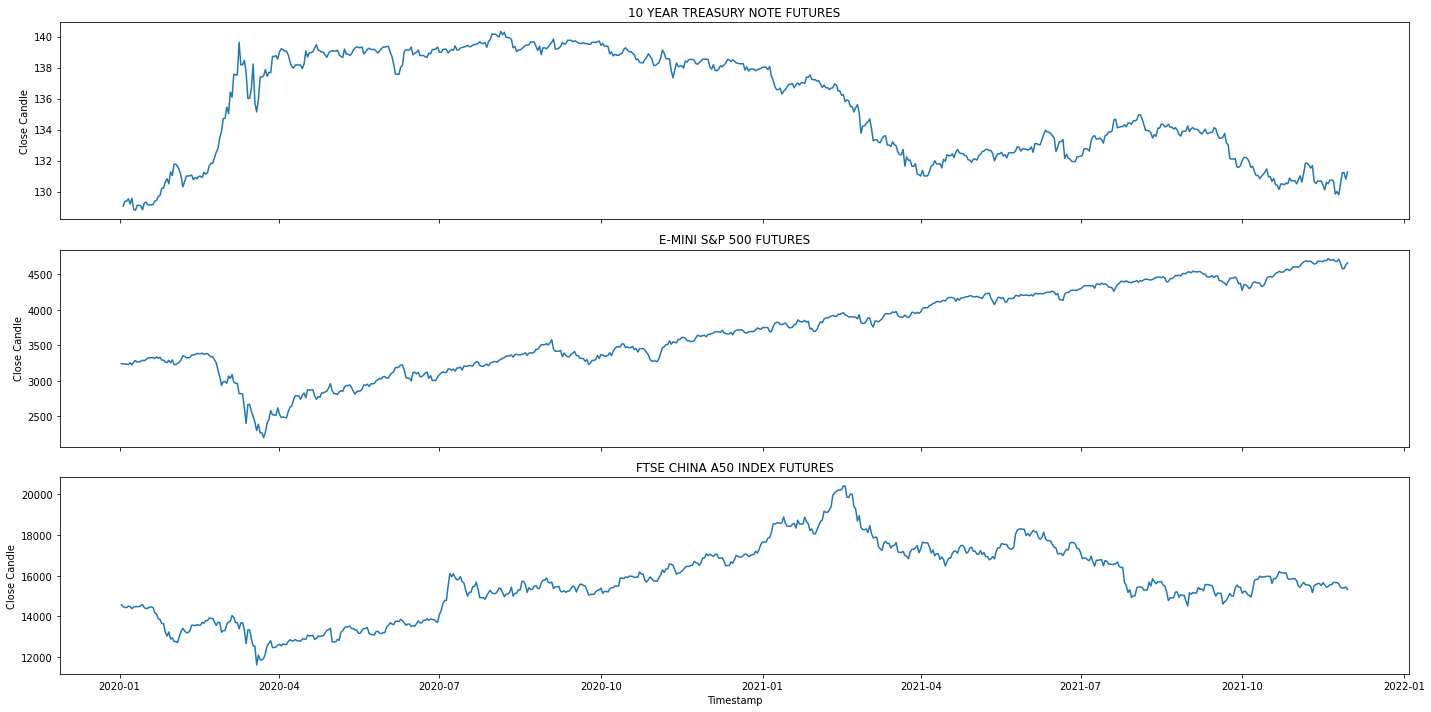

In [11]:
df_daily_close = df_daily_close.dropna(subset=['Close Candle'])
df_daily_close = df_daily_close.groupby('Ticker Full Name').apply(lambda group: group.iloc[1:]).reset_index(drop=True)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)

for i, ticker in enumerate(tickers):
    ticker_data = df_daily_close[df_daily_close['Ticker Full Name'] == ticker]
    axes[i].plot(ticker_data['Timestamp'], ticker_data['Close Candle'])
    axes[i].set_title(ticker)
    axes[i].set_ylabel('Close Candle')

axes[-1].set_xlabel('Timestamp')
plt.tight_layout()
plt.show()

<span style="color:blue">Накладываем графики друг на друга и масштабируем их для визуального исследования.</span>

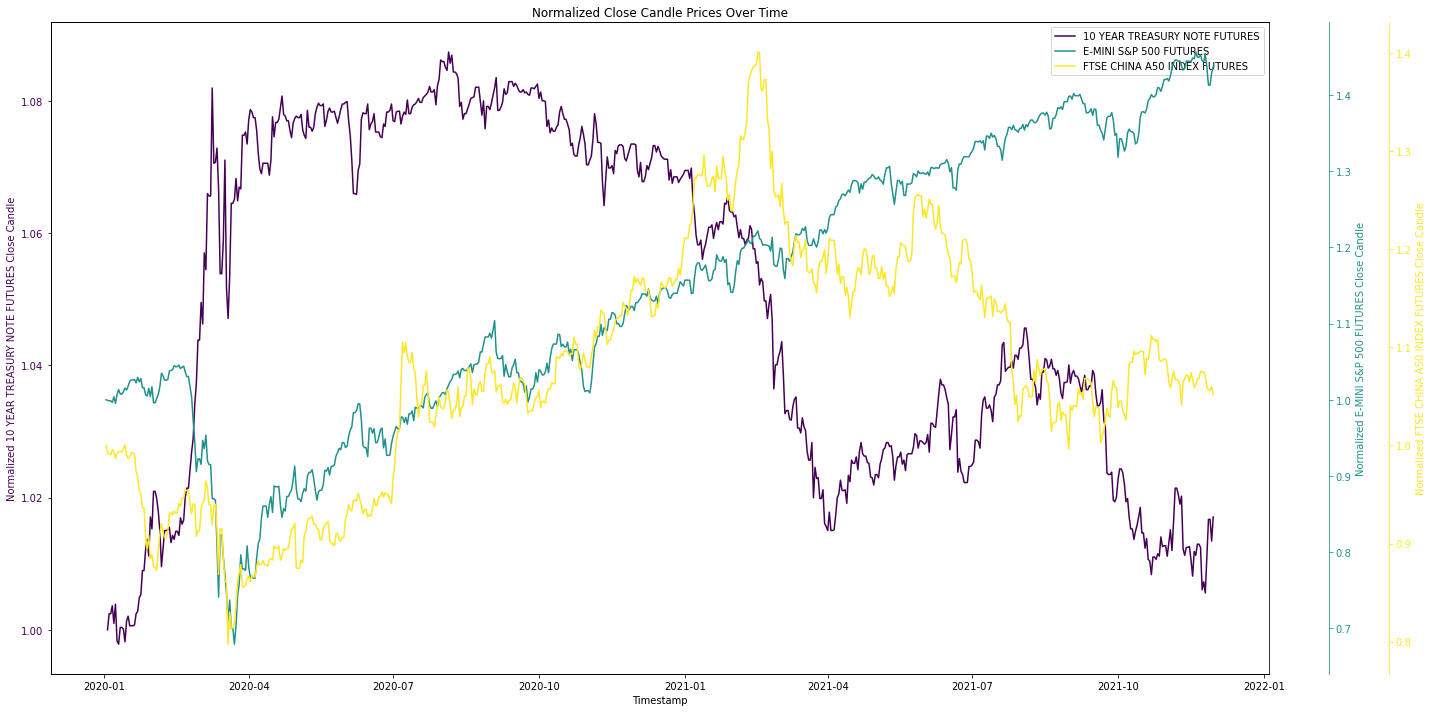

In [12]:
normalized_data = []
for ticker in tickers:
    ticker_data = df_daily_close[df_daily_close['Ticker Full Name'] == ticker].copy()
    ticker_data['Normalized Close Candle'] = ticker_data['Close Candle'] / ticker_data['Close Candle'].iloc[0]
    normalized_data.append(ticker_data)

normalized_df = pd.concat(normalized_data)

fig, ax1 = plt.subplots(figsize=(20, 10))

axes = {}
colors = plt.cm.viridis(np.linspace(0, 1, len(tickers)))  # Выбор цветовой карты

for i, ticker in enumerate(tickers):
    if i == 0:
        axes[ticker] = ax1
    else:
        axes[ticker] = ax1.twinx()
        axes[ticker].spines['right'].set_position(('outward', 60 * i))
        axes[ticker].spines['right'].set_color(colors[i])
        axes[ticker].tick_params(axis='y', colors=colors[i])

for i, ticker in enumerate(tickers):
    ticker_data = normalized_df[normalized_df['Ticker Full Name'] == ticker]
    axes[ticker].plot(ticker_data['Timestamp'], ticker_data['Normalized Close Candle'], label=ticker, color=colors[i])
    axes[ticker].set_ylabel(f'Normalized {ticker} Close Candle', color=colors[i])
    axes[ticker].tick_params(axis='y', labelcolor=colors[i])

ax1.set_xlabel('Timestamp')
ax1.set_title('Normalized Close Candle Prices Over Time')

lines = [axes[ticker].get_lines()[0] for ticker in tickers]
ax1.legend(lines, tickers)

plt.tight_layout()
plt.show()

<span style="color:blue">Визуализация не дает полного представления о взаимосвязи гос. облигаций и индексов акций. Тем более нет возможности вычислить лаги и кто является лидером или фоловером. Единственное, что можно понять, что индексы акций Китайских и американских имеет положительную корреляцию примерно до февраля 2021 года. Далее на Китай начали воздействовать последствия КОВИДА и проблемы в строительном секторе, после чего произошел обвал рынка.  Китай является третьем по величине держателем американского госдолга, поэтому можно предположить, что стоимость гос облигаций будет оказывать влияние на китайские акции, но в гораздо меньшей степени чем на американский рынок. Поэтому зависимость рынка акций (и США и Китая) от облигаций будет, но она в теории должна быть непостоянна и будет изменчива.</span>

<span style="color:blue">Для начала попробуем вычислить лаг с помощью теста Гранджера.  После которого видим что наибольшая зависимость есть у Treasury and SP500 с лагом 2.  Lag 2: parameter F test: F=10.6514 , p=0.0000.
Далее видно, что также есть зависимость Treasury and ChinaA50 с лагом 1. Lag 1:  parameter F test:  F=6.1104  , p=0.0137. Но она гораздо ниже чем для гос. облигаций и SP500. 
Для остальных комбинаций нет четко выраженной зависимости, что подтверждает теорию о том, что акции зависят от гос.облигаций.
Надо обратить внимание, что эти зависимости вычислялись для всего периода, что не может давать полноценного представления.
Попробуем доказать тоже самое, еще одним методом.</span> 

In [13]:
df_daily_close = df_daily_close.set_index(['Ticker Full Name', 'Timestamp'])

treasury_data = df_daily_close.xs('10 YEAR TREASURY NOTE FUTURES', level='Ticker Full Name')['Close Candle']
sp500_data = df_daily_close.xs('E-MINI S&P 500 FUTURES', level='Ticker Full Name')['Close Candle']
china_a50_data = df_daily_close.xs('FTSE CHINA A50 INDEX FUTURES', level='Ticker Full Name')['Close Candle']

data = pd.concat([treasury_data, sp500_data, china_a50_data], axis=1)
data.columns = ['Treasury', 'SP500', 'ChinaA50']

data = data.dropna()

def perform_granger_test(data, var1, var2, max_lag):
    print(f"\nTesting Granger Causality between {var1} and {var2} with max lag {max_lag}")
    results = grangercausalitytests(data[[var1, var2]], maxlag=max_lag, verbose=False)
    
    for lag in range(1, max_lag + 1):
        f_test = results[lag][0]['ssr_ftest']
        f_stat = f_test[0]
        p_value = f_test[1]
        df_denom = f_test[3]
        df_num = f_test[2]
        
        print(f"Lag {lag}: "
              f" parameter F test:  F={f_stat:.4f}  , p={p_value:.4f}  , df_denom={df_denom}, df_num={df_num}")

max_lag = 10

perform_granger_test(data, 'Treasury', 'SP500', max_lag)
perform_granger_test(data, 'SP500', 'Treasury', max_lag)
perform_granger_test(data, 'Treasury', 'ChinaA50', max_lag)
perform_granger_test(data, 'ChinaA50', 'Treasury', max_lag)
perform_granger_test(data, 'ChinaA50', 'SP500', max_lag)
perform_granger_test(data, 'SP500', 'ChinaA50', max_lag)


Testing Granger Causality between Treasury and SP500 with max lag 10
Lag 1:  parameter F test:  F=8.7077  , p=0.0033  , df_denom=1, df_num=694.0
Lag 2:  parameter F test:  F=10.6514  , p=0.0000  , df_denom=2, df_num=691.0
Lag 3:  parameter F test:  F=8.0770  , p=0.0000  , df_denom=3, df_num=688.0
Lag 4:  parameter F test:  F=6.0324  , p=0.0001  , df_denom=4, df_num=685.0
Lag 5:  parameter F test:  F=5.3423  , p=0.0001  , df_denom=5, df_num=682.0
Lag 6:  parameter F test:  F=4.2996  , p=0.0003  , df_denom=6, df_num=679.0
Lag 7:  parameter F test:  F=6.7920  , p=0.0000  , df_denom=7, df_num=676.0
Lag 8:  parameter F test:  F=6.0414  , p=0.0000  , df_denom=8, df_num=673.0
Lag 9:  parameter F test:  F=5.5575  , p=0.0000  , df_denom=9, df_num=670.0
Lag 10:  parameter F test:  F=5.1103  , p=0.0000  , df_denom=10, df_num=667.0

Testing Granger Causality between SP500 and Treasury with max lag 10
Lag 1:  parameter F test:  F=0.1096  , p=0.7407  , df_denom=1, df_num=694.0
Lag 2:  parameter F t

<span style="color:blue"> Прогоним повторный тест с моделью  Векторная авторегрессия (VAR) для всего периода. Результат аналогичный. На графиках можно увидеть наибольшую зависимость между Treasure и SP500 где лидером является  Treasure, SP500 фоловером. Аналогично и для Китайского индекса. У этих двух комбинаций наибольшие Y значения. Также можно увидеть, что данный метод показывает хорошие показатели с логом равным 10. Но для Шанхайского индекса зависимость прямая, а для американского обратная. К тому же, она скорее всего будем меняться или исчезать на различных промежутках времени. Проверим! </span>

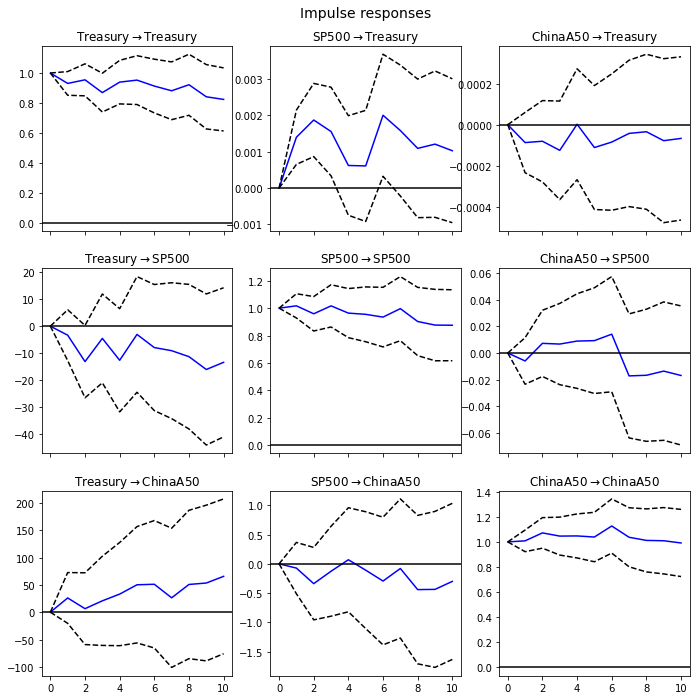

In [14]:
model = VAR(data)
results = model.fit(maxlags=10)

irf = results.irf(10)
irf.plot(orth=False)
plt.show()

<span style="color:blue">Для этого попробуем взять период с февраля 2021, где Шанхайский индекс начал обваливаться. Аналогично, предыдущему периоду можно видеть, что зависимость существует, но уже менее выраженна.</span> 

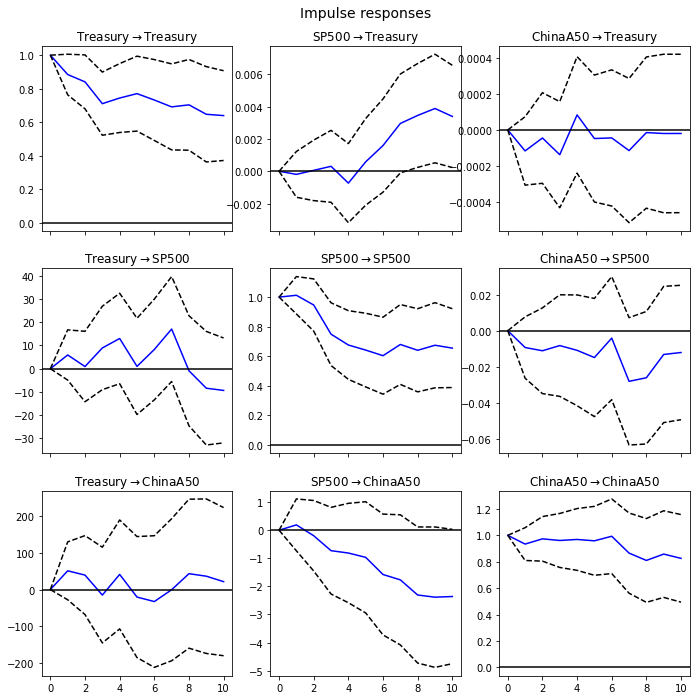

In [15]:
data.index = pd.to_datetime(data.index)

filtered_data = data[data.index >= '2021-02-01']

model = VAR(filtered_data)
results = model.fit(maxlags=10)

irf = results.irf(10)
irf.plot(orth=False)
plt.show()

<span style="color:blue">Вывод. Наибольшая зависимость есть между  Treasure и акциями, где  Treasure - лидер, акции - фолловеры. Лаг может увеличиваться или уменьшаться в зависимости от выбранного временного периода. Наилучший лаг 2 и 1 для США и Китая для данного датасета.</span> 